# Simulation and Inference of Interferometry on Growing Thin Films

We are interested in sumulating the reflectance of growing thin films (forward modeling) and infer the growth behavior from measurements.

Caution: This is work in progress.

## Imports

In [58]:
# numerics
import jax.numpy as jnp
import numpy as np
import jax
import optax

# data reading
import pandas as pd

# plotting
import matplotlib.pyplot as plt

# our library
from reflax import polanalyze, variable_layer_thickness_simulation
from reflax.parameter_classes.parameters import OpticsParams, SetupParams, LayerParams, GrowthModel
from reflax.forward_model.variable_layer_size import power_forward_model
from reflax.data_analysis import cws

## Simulation

### General Setup

Let us first specify parameters of the experimental setup

In [59]:
from reflax.parameter_classes.parameters import SetupParams

wavelength = 632.8
polar_angle = jnp.deg2rad(25)
azimuthal_angle = jnp.deg2rad(0)

setup_params = SetupParams(
    wavelength = wavelength,
    polar_angle = polar_angle,
    azimuthal_angle = azimuthal_angle
)

polarization_state = "Linear TE/perpendicular/s"
transverse_electric_component, transverse_magnetic_component = polanalyze(polarization_state)

We also generally assume

In [60]:
permeability_reflection = 1
permittivity_reflection = 1

permeability_transmission = 1
permittivity_transmission = (3.8827 + 0.019626j)**2

optics_params = OpticsParams(
    permeability_reflection = permeability_reflection,
    permittivity_reflection = permittivity_reflection,
    permeability_transmission = permeability_transmission,
    permittivity_transmission = permittivity_transmission,
    transverse_electric_component = transverse_electric_component,
    transverse_magnetic_component = transverse_magnetic_component
)

backside_mode = 1

and consider a setup with two static-thickness layers with parameters

In [61]:
static_layer_thicknesses = jnp.array([10.0])
permeability_static_size_layers = jnp.array([1.0])
permittivity_static_size_layers = jnp.array([1.45704**2])

static_layer_params = LayerParams(
    permeabilities = permeability_static_size_layers,
    permittivities = permittivity_static_size_layers,
    thicknesses = static_layer_thicknesses
)

Let there further be a layer of variable thickness, with properties

In [62]:
permeability_variable_layer = 1
permittivity_variable_layer = 1.57**2

variable_layer_params = LayerParams(
    permeabilities = permeability_variable_layer,
    permittivities = permittivity_variable_layer
)

### Growth model for the variable layer

We simulate over the timespan

In [63]:
final_time = 7049
time_points = jnp.arange(0, final_time)

Given a linear growth rate

In [64]:
layer_growing_rate = 747.9 / (7049 / 60) / 60

this yields the following thicknesses of the variable layer

In [65]:
variable_layer_thicknesses = time_points * layer_growing_rate

### Running the simulation

In [66]:
reflection_coefficients, transmission_coefficients, conservation_checks = variable_layer_thickness_simulation(
    setup_params = setup_params,
    optics_params = optics_params,
    static_layer_params = static_layer_params,
    variable_layer_params = variable_layer_params,
    variable_layer_thicknesses = variable_layer_thicknesses,
    backside_mode = backside_mode
)

### Profiling the simulation

In [67]:
%%timeit
reflection_coefficients, transmission_coefficients, conservation_checks = jax.block_until_ready(variable_layer_thickness_simulation(
    setup_params = setup_params,
    optics_params = optics_params,
    static_layer_params = static_layer_params,
    variable_layer_params = variable_layer_params,
    variable_layer_thicknesses = variable_layer_thicknesses,
    backside_mode = backside_mode
))

4.63 ms ± 265 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Interactive Plotting

In [ ]:
from ipywidgets import interact
import ipywidgets as widgets
@interact(vfac = 1.0, a_fac = 0.0, perm = 1.57**2)
def int_plot(vfac, a_fac, perm):
    reflection_coefficients, transmission_coefficients, conservation_checks = variable_layer_thickness_simulation(
        setup_params = setup_params,
        optics_params = optics_params,
        static_layer_params = static_layer_params,
        variable_layer_params = variable_layer_params._replace(permittivities = perm),
        variable_layer_thicknesses = variable_layer_thicknesses * vfac + variable_layer_thicknesses ** 2 * a_fac,
        backside_mode = backside_mode
    )
    plt.plot(time_points, conservation_checks * 100, '-g', linewidth=1, label="Conservation")
    plt.plot(time_points, reflection_coefficients * 100, '-b', linewidth=1, label="Reflectance")
    plt.plot(time_points, transmission_coefficients * 100, '-r', linewidth=1, label="Transmittance")
    plt.plot(time_points, 35 * jnp.sin(1/630 * (time_points + 340)) ** 2 + 61)
    plt.xlim([0, final_time])
    plt.ylim([0, 110])
    plt.xlabel("Time in s")
    plt.ylabel("Power fractions in %")
    plt.legend(loc="upper right")

interactive(children=(FloatSlider(value=1.0, description='vfac', max=3.0, min=-1.0), FloatSlider(value=0.0, de…

## Data Analysis

Text(0.5, 1.0, 'measurement')

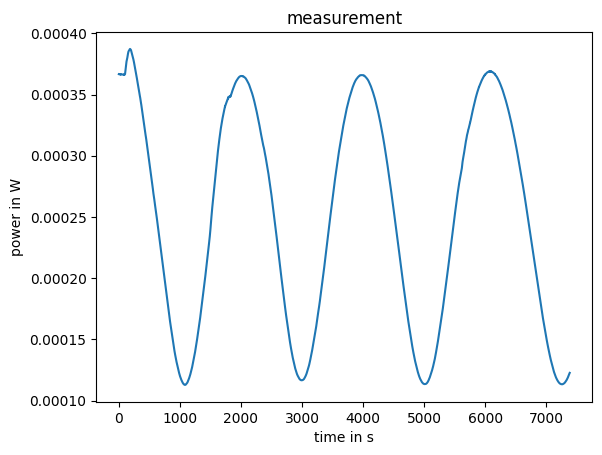

In [69]:
# Define the CSV file path
file_path = 'data/measurement.csv'

# Read the CSV, skipping rows until the data table starts
df = pd.read_csv(file_path, sep=';', skiprows=14, decimal=',')
df.columns = df.columns.str.strip()

# Strip whitespace and convert to datetime objects
df['Time'] = pd.to_datetime(df['Time of day (hh:mm:ss)'].str.strip(), format='%H:%M:%S.%f')

# Calculate time since the start
start_time = df['Time'].iloc[0]
df['Time Since Start (seconds)'] = (df['Time'] - start_time).dt.total_seconds()

# Save as jnp arrays
time_points_measured = jnp.asarray(df['Time Since Start (seconds)'])
power_measured = jnp.asarray(df["Power (W)"])

# Display the result
plt.plot(time_points_measured, power_measured)
plt.xlabel("time in s")
plt.ylabel("power in W")
plt.title("measurement")


There seem to be artefacts in the measurement at the beginning up until ~1800 seconds (see the non-smooth transition there). We will cut this part of the measurement away.

In [70]:
time_points_measured = time_points_measured[500:]
power_measured = power_measured[500:]

Which looks much better

Text(0.5, 1.0, 'cleaned measurement')

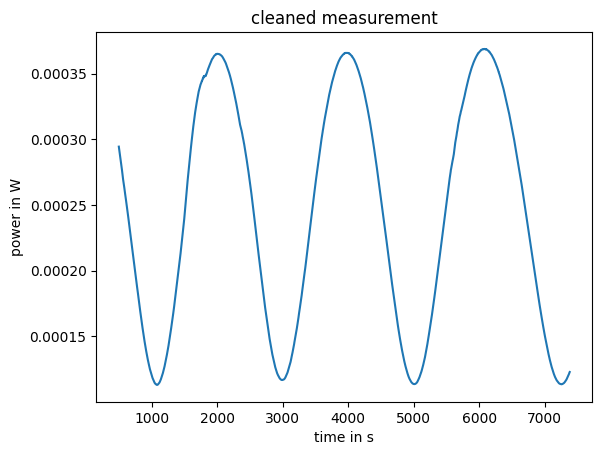

In [71]:
plt.plot(time_points_measured, power_measured)
plt.xlabel("time in s")
plt.ylabel("power in W")
plt.title("cleaned measurement")

### Wavelet analysis

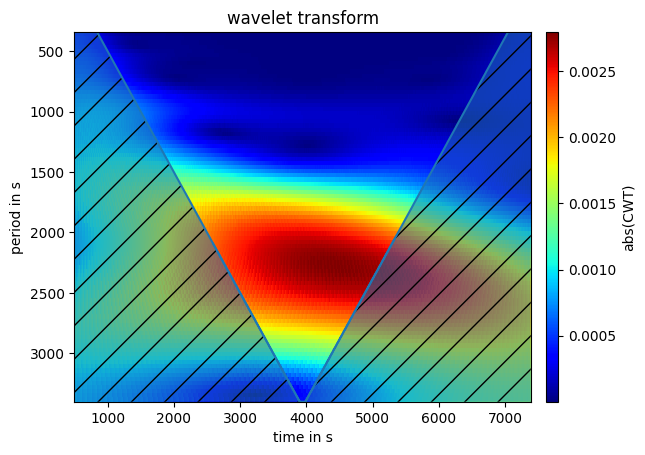

In [72]:
def plot_scaleogram(ax, time_points, signal, title, ylabel = "period in s", xlabel = "time in s", cbarlabel = "abs(CWT)", yscale = "linear", cscale = "linear", scales = np.arange(10, 1000, 10), clim = None, coi=True): # scales = np.arange(100, 2200, 20)
    cws(time = time_points, signal = signal, ax = ax, scales = scales, wavelet="cmor1-1.5", coikw={'alpha':0.5,'hatch':'/'}, ylabel = ylabel, xlabel = xlabel, title = title, cscale = cscale, yscale = yscale, cbarlabel = cbarlabel, clim = clim, coi=coi)

fig, ax = plt.subplots()
plot_scaleogram(ax, time_points_measured, power_measured, "wavelet transform", scales = np.arange(500, 5000, 50), coi=True)


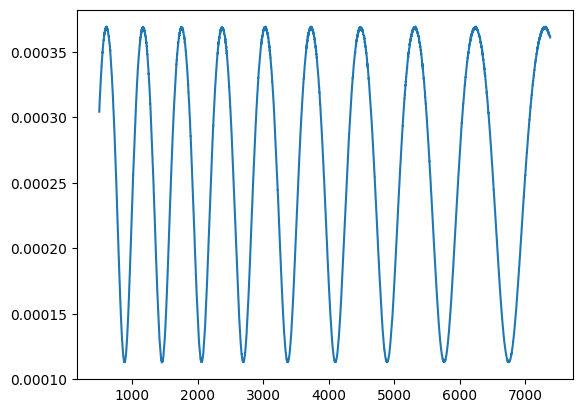

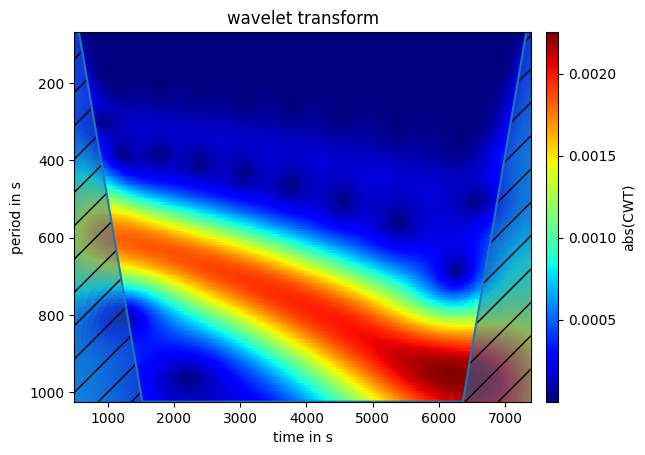

In [73]:
initial_layer_thickness = 170
layer_growing_rate = 0.4
layer_growing_acceleration = -3e-5

growth_model = GrowthModel(
    initial_thickness = initial_layer_thickness,
    growth_velocity = layer_growing_rate,
    growth_acceleration = layer_growing_acceleration
)

power_conversion_factor = 0.00075
power_conversion_constant = 0.00008

power_simulated = power_forward_model(
    setup_params = setup_params,
    optics_params = optics_params,
    static_layer_params = static_layer_params,
    variable_layer_params = variable_layer_params,
    timepoints_measured = time_points_measured,
    growth_model = growth_model,
    power_conversion_factor = power_conversion_factor,
    power_conversion_constant = power_conversion_constant,
    backside_mode = backside_mode
)

plt.plot(time_points_measured, power_simulated)

fig, ax = plt.subplots()
plot_scaleogram(ax, time_points_measured, power_simulated, "wavelet transform", scales = np.arange(100, 1500, 10), coi=True)

## Inference

### Inference by hand

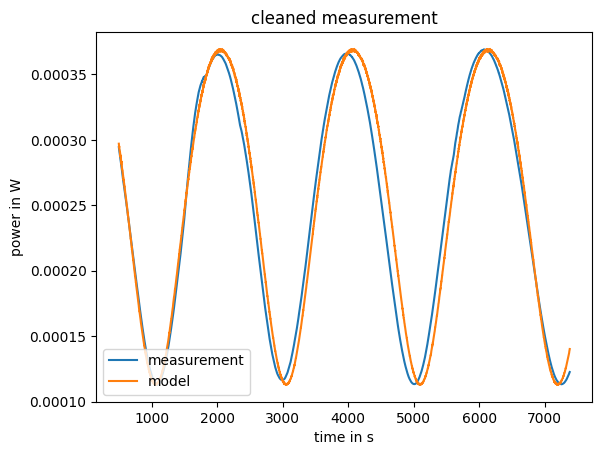

In [74]:
# initial_layer_thickness = 170
# layer_growing_rate = 747.9 / (7049 / 60) / 60
# layer_growing_acceleration = -0.0000004

# 1.7000000e+02  1.0696702e-01 -5.1498353e-07
# 1.07924394e-01 -6.79976267e-07

initial_layer_thickness = -20
layer_growing_rate = 1.07924394e-01
layer_growing_acceleration = -6.79976267e-07
# layer_growing_acceleration = 0

permeability_variable_layer = 1
permittivity_variable_layer = 1.57**2

variable_layer_params = LayerParams(
    permeabilities = permeability_variable_layer,
    permittivities = permittivity_variable_layer
)

# simple accelerated model
layer_thickness_model = initial_layer_thickness + layer_growing_rate * time_points_measured + layer_growing_acceleration * time_points_measured ** 2

reflection_coefficients, _, _ = variable_layer_thickness_simulation(
        setup_params = setup_params,
        optics_params = optics_params,
        static_layer_params = static_layer_params,
        variable_layer_params = variable_layer_params,
        variable_layer_thicknesses = layer_thickness_model,
        backside_mode = backside_mode
    )

power_conversion_factor = 0.00075
power_conversion_constant = 0.00008

# power_conversion_factor = 3.32e-4
# power_conversion_constant = 0.00006

power_model = power_conversion_factor * reflection_coefficients + power_conversion_constant

plt.plot(time_points_measured, power_measured, label = "measurement")
plt.plot(time_points_measured, power_model, label = "model")
plt.xlabel("time in s")
plt.ylabel("power in W")
plt.title("cleaned measurement")
plt.legend(loc = "lower left")

### Computational optimization

[-3.1447020e+01  1.3574445e-01 -4.0779528e-06  1.8675795e+00]
-31.44702
859.6864


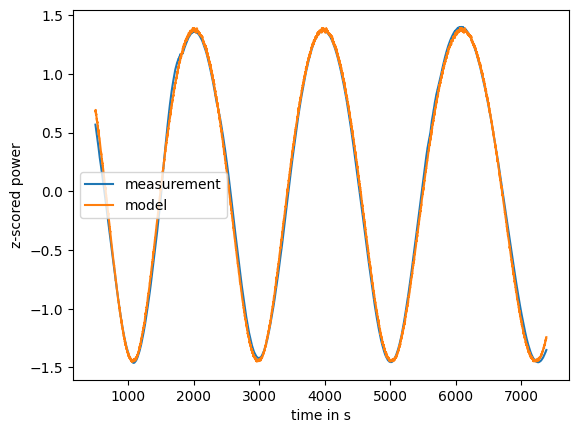

In [ ]:
from reflax import power_forward_residuals
from reflax.forward_model.variable_layer_size import TRANSFER_MATRIX_METHOD

# initial_guess_x = jnp.array([initial_layer_thickness, layer_growing_rate, layer_growing_acceleration, permittivity_variable_layer, power_conversion_factor, power_conversion_constant])

initial_guess_x = jnp.array([initial_layer_thickness, layer_growing_rate, layer_growing_acceleration, permittivity_variable_layer])

# def residuals(params, consts):
#     initial_thickness, growth_velocity, growth_acceleration, variable_layer_permittivity, power_conversion_factor, power_conversion_constant = params * initial_guess_x
#     residuals = jnp.zeros((time_points_measured.shape[0] + 1,))

#     residuals = residuals.at[:-1].set(power_forward_residuals(
#         setup_params = setup_params,
#         optics_params = optics_params,
#         static_layer_params = static_layer_params,
#         variable_layer_params = variable_layer_params._replace(permittivities = variable_layer_permittivity),
#         timepoints_measured = time_points_measured,
#         growth_model = growth_model._replace(initial_thickness = initial_thickness, growth_velocity = growth_velocity, growth_acceleration = growth_acceleration),
#         power_conversion_factor = power_conversion_factor,
#         power_conversion_constant = power_conversion_constant,
#         backside_mode = backside_mode,
#         power_measured = power_measured
#     ))

#     residuals = residuals.at[-1].set((initial_thickness + growth_velocity * time_points_measured[-1] + 1/2 * growth_acceleration * time_points_measured[-1] ** 2 - 771.83))

#     return residuals

# z-score power measured
power_measured_z = (power_measured - jnp.mean(power_measured)) / jnp.std(power_measured)

model = TRANSFER_MATRIX_METHOD

def residuals(params, consts):
    initial_thickness, growth_velocity, growth_acceleration, variable_layer_permittivity = params * initial_guess_x
    reflection_coefficients, _, _ = variable_layer_thickness_simulation(
        setup_params = setup_params,
        optics_params = optics_params,
        static_layer_params = static_layer_params,
        variable_layer_params = variable_layer_params._replace(permittivities = variable_layer_permittivity),
        variable_layer_thicknesses = initial_thickness + growth_velocity * time_points_measured + 1/2 * growth_acceleration * time_points_measured ** 2,
        backside_mode = backside_mode
    )

    power_model_z = (reflection_coefficients - jnp.mean(reflection_coefficients)) / jnp.std(reflection_coefficients)

    residuals = power_measured_z - power_model_z

    return residuals

initial_guess = jnp.array([1.0, 1.0, 1.0, 1.0])
# x, xlist, loss_list = gradient_descent_optimization(loss, initial_guess)

import optimistix as optx

solver = optx.LevenbergMarquardt(
    rtol=1e-8, atol=1e-8
)

def swarm_least_squares_optimization(residuals, solver, initial_guess, variances, num_bees, random_key):
    random_normal_matrix = jax.random.normal(random_key, shape = ((initial_guess.shape[0], num_bees)))
    initial_condition_matrix = jnp.zeros((initial_guess.shape[0], num_bees + 1))
    initial_condition_matrix = initial_condition_matrix.at[:, :-1].set(initial_guess[:, None] + random_normal_matrix * jnp.sqrt(variances)[:, None])
    initial_condition_matrix = initial_condition_matrix.at[:, -1].set(initial_guess)

    # vmap optx.least_squares(residuals, solver, initial_guess).value over the bees
    def single_bee(guess):
        sol_arr = jnp.zeros((initial_guess.shape[0] + 1,))
        sol = optx.least_squares(residuals, solver, guess)
        sol_arr = sol_arr.at[:-1].set(sol.value)
        sol_arr = sol_arr.at[-1].set(jnp.sum(residuals(sol.value, None)**2))
        return sol_arr
    
    sol_arr = jax.vmap(single_bee)(initial_condition_matrix.T).T
    best_guess = sol_arr[:-1, jnp.argmin(sol_arr[-1, :])]
    return best_guess
    

seed = 1701
key = jax.random.key(seed)

sol = optx.least_squares(residuals, solver, initial_guess).value

num_bees = 20
variances = jnp.array([0.4, 0.4, 0.4, 0.4])
# sol_bees = swarm_least_squares_optimization(residuals, solver, initial_guess, variances, num_bees, key)

plt.plot(time_points_measured, power_measured_z, label = "measurement")
# plt.plot(time_points_measured, power_measured_z + residuals(sol, None)[:-1], label = "model")

initial_thickness, growth_velocity, growth_acceleration, variable_layer_permittivity = sol * initial_guess_x

reflection_coefficients, _, _ = variable_layer_thickness_simulation(
    setup_params = setup_params,
    optics_params = optics_params,
    static_layer_params = static_layer_params,
    variable_layer_params = variable_layer_params._replace(permittivities = variable_layer_permittivity),
    variable_layer_thicknesses = initial_thickness + growth_velocity * time_points_measured + 1/2 * growth_acceleration * time_points_measured ** 2,
    backside_mode = backside_mode
)

power_model_z = (reflection_coefficients - jnp.mean(reflection_coefficients)) / jnp.std(reflection_coefficients)


plt.plot(time_points_measured, power_model_z, label = "model")

plt.legend()
plt.xlabel("time in s")
plt.ylabel("z-scored power")

print(sol * initial_guess_x)
# print(sol_bees * initial_guess_x)

# initial_thickness, growth_velocity, growth_acceleration, _, _, _ = sol * initial_guess_x

final_thickness = initial_thickness + growth_velocity * time_points_measured[-1] + 1/2 * growth_acceleration * time_points_measured[-1] ** 2

print(initial_thickness)
print(final_thickness)